# Analysis of non-cycling microglia from experiment 1

This notebook generates major results in Figures 3 and 7E for the non-cycling microglia from Experiment 1 (without transcription and translation inhibitors).

# Preparation

This list includes the necessary packages to run the notebook, along with some that may not be required here but are commonly used for exploring adata.

In [56]:
import os
import re
import time
import glob
import csv
import seqc
import h5py
import tables
import seqc.filter
import warnings
import itertools
import harmony
import palantir as pl
import scvelo as scv
import cellrank as cr
import collections
import statsmodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import doubletdetection
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import seaborn as sns
import scrublet as scr
import anndata as ad
import networkx as nx
import logging
import scipy.cluster.hierarchy as shc
import scanpy.external as sce
import logging

from pathlib import Path
from typing import Dict
from scipy import sparse
from scipy import io
from scipy.sparse.csgraph import connected_components
from sklearn.preprocessing import normalize
from itertools import compress
from kneed import KneeLocator
from copy import deepcopy
from seqc import plot
from seqc.plot import FigureGrid
from collections import OrderedDict
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from seqc.sparse_frame import SparseFrame
from scipy.io import mmwrite
from adjustText import adjust_text

In [15]:
# Define and customize plot attributes
%matplotlib inline
sc.set_figure_params(dpi=80) 

sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = [4,4]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.style.use("ggplot")
mpl.rcdefaults()
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Initialize

In [16]:
# Change directory to the desired path:
DATA_DIR = '/data/massague/gans/projects/Breast_tumor/GitHub/Data/'

# Sub-directory for the data of non-cycling microglia from experiment 1 
source = 'Non_Cycling_MG_1/'

# Processed adata
for h5_file in Path(DATA_DIR+source).glob('*.h5'):    
    adata = sc.read(h5_file) # Log-transformed, normalized data

## Load MILO results

### Neighborhood indexes and cell counts

In [17]:
# Directory for the Milo results
MILO_DIR = DATA_DIR+source+'Milo/'

# 'None' in the file name indicates that transcription and translation inhibitors are not added:
nhoodIdx = (pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_milo.nhoodIndex.csv', index_col=0)-1).T

# Each row in column "1": the index cell per Milo neighborhood
nhoodIdx

,1
X363,362
X5188,5187
X4245,4244
X4574,4573
X7953,7952
...,...
X3911,3910
X9706,9705
X7024,7023
X6836,6835


In [18]:
nhoodCounts = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_milo.nhoodCounts.csv', index_col=0)

# Number of cells from each source per neighborhood
nhoodCounts 

,HER2BC_Unlabeled,TNBC_Unlabeled,HER2BC_Labeled,TNBC_Labeled
1,40,1,29,51
2,8,0,87,58
3,3,0,18,2
4,2,0,31,61
5,0,0,7,31
...,...,...,...,...
568,0,0,5,48
569,15,4,2,28
570,8,1,15,108
571,11,0,6,28


In [19]:
# Update row names in the above Milo results to match the corresponding obs_names of adata
nhoodIdx.index = adata.obs_names[nhoodIdx][:,0]
nhoodCounts.index = nhoodIdx.index

### Generalized linear model (GLM) fit results

In [20]:
fit = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_milo.nhoodCountsFit.csv', index_col=0)
fit.index = nhoodIdx.index
fit

,(Intercept),groupHER2BC_Labeled,groupTNBC_Labeled
Unlabeled_stromal_cells_239451619092844-0-0,0.807763,0.262866,0.806543
Labeled_stromal_cells_135496128154852-1-0,-0.788050,2.954118,2.530640
Labeled_stromal_cells_200493056781029-1-0,-1.689112,2.285716,0.130146
Labeled_stromal_cells_134445202820004-1-0,-2.047141,3.184155,3.840043
Labeled_stromal_cells_125813258934123-1-0,-4.278621,3.942688,5.396867
...,...,...,...
Labeled_stromal_cells_191148435131699-1-0,-4.278621,3.613944,5.832475
Labeled_stromal_cells_161529247951595-1-0,0.121565,-1.662910,0.895384
Labeled_stromal_cells_166273863806235-1-0,-0.639489,1.055298,3.002644
Labeled_stromal_cells_226884395657117-1-0,-0.481250,-0.005606,1.498199


In [21]:
# Add UMAP embedding results to assist downstream visualization
fit.loc[:,['UMAP_1','UMAP_2']] = adata[fit.index].obsm['X_umap']
fit

,(Intercept),groupHER2BC_Labeled,groupTNBC_Labeled,UMAP_1,UMAP_2
Unlabeled_stromal_cells_239451619092844-0-0,0.807763,0.262866,0.806543,-3.512622,2.348929
Labeled_stromal_cells_135496128154852-1-0,-0.788050,2.954118,2.530640,-2.206457,6.565991
Labeled_stromal_cells_200493056781029-1-0,-1.689112,2.285716,0.130146,4.283952,10.541632
Labeled_stromal_cells_134445202820004-1-0,-2.047141,3.184155,3.840043,1.564687,4.073106
Labeled_stromal_cells_125813258934123-1-0,-4.278621,3.942688,5.396867,1.633611,2.815432
...,...,...,...,...,...
Labeled_stromal_cells_191148435131699-1-0,-4.278621,3.613944,5.832475,1.271186,6.228439
Labeled_stromal_cells_161529247951595-1-0,0.121565,-1.662910,0.895384,-2.099930,0.567758
Labeled_stromal_cells_166273863806235-1-0,-0.639489,1.055298,3.002644,-2.660627,4.581704
Labeled_stromal_cells_226884395657117-1-0,-0.481250,-0.005606,1.498199,-2.077898,4.382718


In [22]:
# Note the fit results have also been added to the adata provided, using: 
adata.obs['GLM_coeff_HER2BC_Labeled'] = np.nan
adata.obs['GLM_coeff_TNBC_Labeled'] = np.nan

adata.obs['GLM_coeff_HER2BC_Labeled'][fit.index] = fit.loc[:,'groupHER2BC_Labeled']
adata.obs['GLM_coeff_TNBC_Labeled'][fit.index] = fit.loc[:,'groupTNBC_Labeled']

### Differential abundance results

In [23]:
# da: "differential abundance", saved as a dictionary, with the keys set to the groups compared
da = {}

In [24]:
for k in ['TNvsHER2', 'TNvsCtrl', 'HER2vsCtrl', 'LabeledvsCtrl']:
    
    da[k] = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_milo.da_'+k+'.csv', index_col=0)

    # Note "-1" comes from the fact that index starts from 1 in R and from 0 in Python
    # To match the Milo results obtained in R to Python, need to -1
    da[k].loc[:,'Nhood'] = da[k].index-1

    da[k].index = nhoodIdx.index
    da[k].loc[:,'neg_log10(SpatialFDR)'] = -np.log10(da[k].loc[:,'SpatialFDR'])

    # Total No. of cells in the neighborhood
    da[k].loc[:,'nhood_size'] = nhoodCounts.sum(axis=1).to_numpy()
    
    # Update results to adata
    adata.obs[k+'_neg_log10(SpatialFDR)'] = np.nan
    adata.obs[k+'_neg_log10(SpatialFDR)'][da[k].index] = da[k].loc[:,'neg_log10(SpatialFDR)']
    fit.loc[:,k+'_neg_log10(SpatialFDR)'] = da[k].loc[fit.index,'neg_log10(SpatialFDR)']
    
    if k != 'LabeledvsCtrl':
        adata.obs[k+'_logFC'] = np.nan
        adata.obs[k+'_logFC'][da[k].index] = da[k].loc[:,'logFC']
        fit.loc[:,k+'_logFC'] = da[k].loc[fit.index,'logFC']
        
fit.loc[:,'nhood_size'] = da['TNvsHER2'].loc[fit.index,'nhood_size']
fit

,(Intercept),groupHER2BC_Labeled,groupTNBC_Labeled,UMAP_1,UMAP_2,TNvsHER2_neg_log10(SpatialFDR),TNvsHER2_logFC,TNvsCtrl_neg_log10(SpatialFDR),TNvsCtrl_logFC,HER2vsCtrl_neg_log10(SpatialFDR),HER2vsCtrl_logFC,LabeledvsCtrl_neg_log10(SpatialFDR),nhood_size
Unlabeled_stromal_cells_239451619092844-0-0,0.807763,0.262866,0.806543,-3.512622,2.348929,0.041137,0.784360,0.190416,1.163595,0.054077,0.379235,0.067077,121
Labeled_stromal_cells_135496128154852-1-0,-0.788050,2.954118,2.530640,-2.206457,6.565991,0.035263,-0.610950,0.846146,3.650942,1.122598,4.261891,0.779368,153
Labeled_stromal_cells_200493056781029-1-0,-1.689112,2.285716,0.130146,4.283952,10.541632,0.083365,-3.109831,0.014001,0.187760,0.790414,3.297591,0.594857,23
Labeled_stromal_cells_134445202820004-1-0,-2.047141,3.184155,3.840043,1.564687,4.073106,0.047549,0.946247,1.379324,5.540011,1.200680,4.593764,1.155095,94
Labeled_stromal_cells_125813258934123-1-0,-4.278621,3.942688,5.396867,1.633611,2.815432,0.083365,2.097937,1.601226,7.786033,1.273872,5.688096,1.549952,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Labeled_stromal_cells_191148435131699-1-0,-4.278621,3.613944,5.832475,1.271186,6.228439,0.083365,3.200663,1.699880,8.414483,1.149827,5.213819,1.733585,53
Labeled_stromal_cells_161529247951595-1-0,0.121565,-1.662910,0.895384,-2.099930,0.567758,0.083365,3.690838,0.243298,1.291766,0.428261,-2.399072,0.413702,49
Labeled_stromal_cells_166273863806235-1-0,-0.639489,1.055298,3.002644,-2.660627,4.581704,0.083365,2.809426,1.060130,4.331899,0.268698,1.522473,0.841617,132
Labeled_stromal_cells_226884395657117-1-0,-0.481250,-0.005606,1.498199,-2.077898,4.382718,0.083365,2.169532,0.482739,2.161444,0.001560,-0.008088,0.304461,45


### Adjacency matrix of neighbors

In [25]:
# Number of neighbors: i.e., number of cells shared between different neighborhoods (off-diagonal)
# On the diagonal line, number of cells per neighborhood 

nhoodAdj = pd.read_csv(MILO_DIR+'Tr_tl_inhibitors_None_milo.nhoodIndex.adj.csv', index_col=0)
nhoodAdj

,363,5188,4245,4574,7953,8034,8715,4095,3588,91,...,3504,566,3676,2432,5882,3911,9706,7024,6836,3245
363,121,1,0,0,0,3,0,0,0,2,...,0,10,0,0,0,0,0,1,1,0
5188,1,153,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,2,0
4245,0,0,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4574,0,0,0,94,0,0,0,7,5,0,...,0,0,0,0,0,0,0,0,0,0
7953,0,0,0,0,38,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,53,0,0,0,3
9706,0,0,0,0,0,6,0,0,0,9,...,0,2,0,0,0,0,49,1,1,0
7024,1,11,0,0,0,1,0,0,0,0,...,0,2,0,0,1,0,1,132,6,0
6836,1,2,0,0,0,2,0,0,0,0,...,0,0,0,0,1,0,1,6,45,0


In [26]:
# Update row and column names to obs_names of the index cells of the neighborhoods 
nhoodAdj.index = nhoodIdx.index
nhoodAdj.columns = nhoodIdx.index
nhoodAdj

,Unlabeled_stromal_cells_239451619092844-0-0,Labeled_stromal_cells_135496128154852-1-0,Labeled_stromal_cells_200493056781029-1-0,Labeled_stromal_cells_134445202820004-1-0,Labeled_stromal_cells_125813258934123-1-0,Labeled_stromal_cells_169019644270876-1-0,Labeled_stromal_cells_241046931326827-1-0,Labeled_stromal_cells_122499672525037-1-0,Labeled_stromal_cells_121399074215723-1-0,Unlabeled_stromal_cells_129440043460405-0-0,...,Labeled_stromal_cells_133828587940267-1-0,Unlabeled_stromal_cells_191767550213406-0-0,Labeled_stromal_cells_191767581941094-1-0,Labeled_stromal_cells_204840369769757-1-0,Labeled_stromal_cells_120864485533430-1-0,Labeled_stromal_cells_191148435131699-1-0,Labeled_stromal_cells_161529247951595-1-0,Labeled_stromal_cells_166273863806235-1-0,Labeled_stromal_cells_226884395657117-1-0,Labeled_stromal_cells_170122135132966-1-0
Unlabeled_stromal_cells_239451619092844-0-0,121,1,0,0,0,3,0,0,0,2,...,0,10,0,0,0,0,0,1,1,0
Labeled_stromal_cells_135496128154852-1-0,1,153,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,2,0
Labeled_stromal_cells_200493056781029-1-0,0,0,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Labeled_stromal_cells_134445202820004-1-0,0,0,0,94,0,0,0,7,5,0,...,0,0,0,0,0,0,0,0,0,0
Labeled_stromal_cells_125813258934123-1-0,0,0,0,0,38,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Labeled_stromal_cells_191148435131699-1-0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,53,0,0,0,3
Labeled_stromal_cells_161529247951595-1-0,0,0,0,0,0,6,0,0,0,9,...,0,2,0,0,0,0,49,1,1,0
Labeled_stromal_cells_166273863806235-1-0,1,11,0,0,0,1,0,0,0,0,...,0,2,0,0,1,0,1,132,6,0
Labeled_stromal_cells_226884395657117-1-0,1,2,0,0,0,2,0,0,0,0,...,0,0,0,0,1,0,1,6,45,0


# Analysis & Visualization

## Examine the differential sample distribution 

Since many visualization and analysis steps rely on a random number seed, each run may produce slight variations. For consistency in this illustration, we load and use the data as processed in the manuscript.

<b> Sample colors: </b>

1) HER2BC_Labeled
2) TNBC_Unlabeled
3) TNBC_Labeled
4) HER2BC_Unlabeled

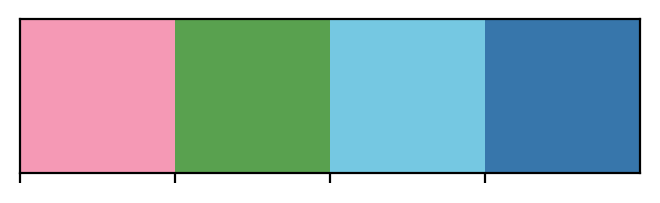

In [27]:
# Reset the colors if needed: 
adata.uns['sample_confirmed_colors'] = ['#F599B5', '#59a14f', '#75C8E2', '#3776ab']
sns.palplot(adata.uns['sample_confirmed_colors'])

<b> Scatter plot </b>

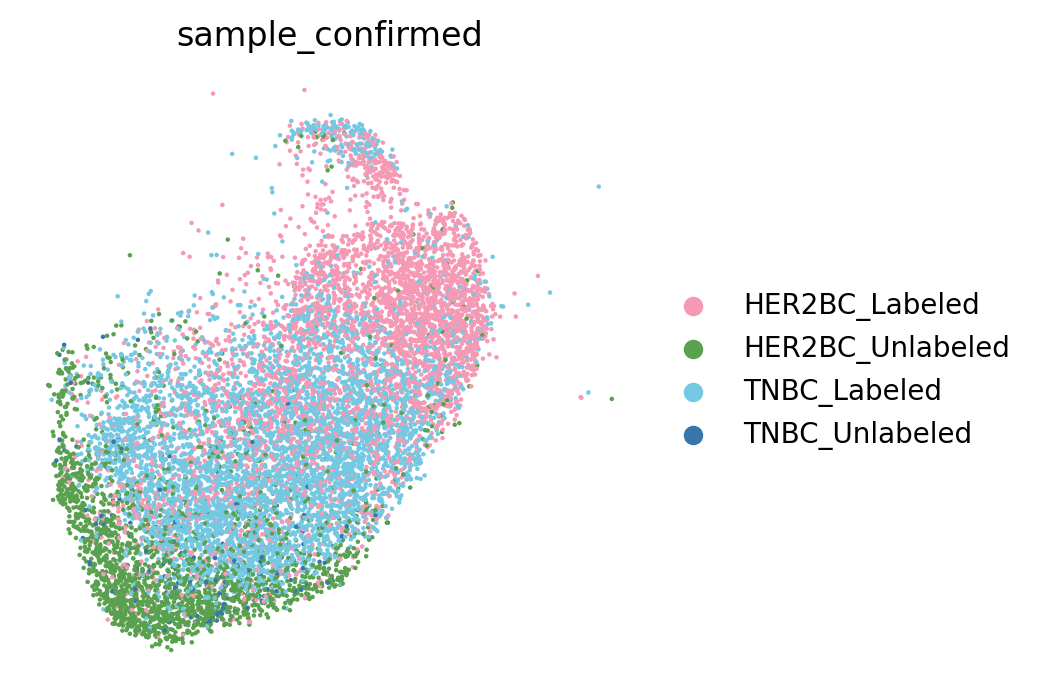

In [28]:
# Randomize the order of data points to plot
vis_rand = np.random.choice(range(adata.shape[0]),replace=False, size=adata.shape[0])

mpl.rcParams['figure.figsize'] = [4,4]
sc.pl.umap(adata[vis_rand],
           color=['sample_confirmed'],
           frameon=False)

<b> Contour plot </b>

In [29]:
# data_plot: UMAP embedding of the cells
data_plot = pd.DataFrame(adata.obsm["X_umap"], 
                         index = adata.obs_names,
                         columns = ["UMAP_1","UMAP_2"])

# "sample_confirmed": the confirmed sources of the cells
data_plot = pd.concat([data_plot, adata.obs["sample_confirmed"]],
                      axis=1).reindex(data_plot.index)

data_plot

,UMAP_1,UMAP_2,sample_confirmed
Unlabeled_stromal_cells_231349310609117-0-0,2.332877,1.332560,HER2BC_Unlabeled
Unlabeled_stromal_cells_232328282107164-0-0,1.870148,0.917485,HER2BC_Unlabeled
Unlabeled_stromal_cells_130615013238644-0-0,3.690597,4.433323,HER2BC_Unlabeled
Unlabeled_stromal_cells_201446646471582-0-0,0.237947,-0.251084,HER2BC_Unlabeled
Unlabeled_stromal_cells_165260098394550-0-0,1.820139,0.834427,HER2BC_Unlabeled
...,...,...,...
Labeled_stromal_cells_205984025725876-1-0,-0.036284,2.401060,TNBC_Labeled
Labeled_stromal_cells_196569623587118-1-0,-2.295782,5.694024,TNBC_Labeled
Labeled_stromal_cells_232448525777644-1-0,-2.745059,1.640030,TNBC_Labeled
Labeled_stromal_cells_228049567731036-1-0,0.065208,1.038894,TNBC_Labeled


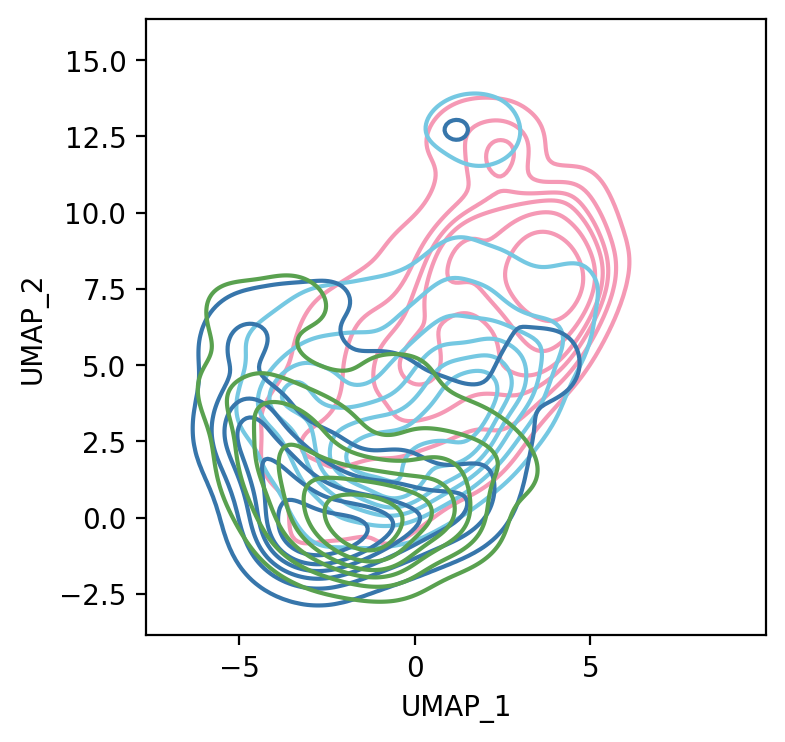

In [30]:
plt.show()

ax = sns.kdeplot(data = data_plot.loc[data_plot['sample_confirmed'] == 'HER2BC_Labeled',:],
                 levels=7, x="UMAP_1", y="UMAP_2", label='HER2BC_Labeled', color='#F599B5')

sns.kdeplot(data = data_plot.loc[data_plot['sample_confirmed'] == 'TNBC_Labeled',:],
            levels=7, x="UMAP_1", y="UMAP_2", ax=ax, label='TNBC_Labeled', color='#75C8E2')

sns.kdeplot(data = data_plot.loc[data_plot['sample_confirmed'] == 'HER2BC_Unlabeled',:],
            levels=7, x="UMAP_1", y="UMAP_2", ax=ax, label='HER2BC_Unlabeled', color='#3776ab') 


sns.kdeplot(data = data_plot.loc[data_plot['sample_confirmed'] == 'TNBC_Unlabeled',:],
            levels=7, x="UMAP_1", y="UMAP_2", ax=ax, label='TNBC_Unlabeled', color='#59a14f') 

ax.grid(False)

<b> Milo results on the differential sample abundance </b>

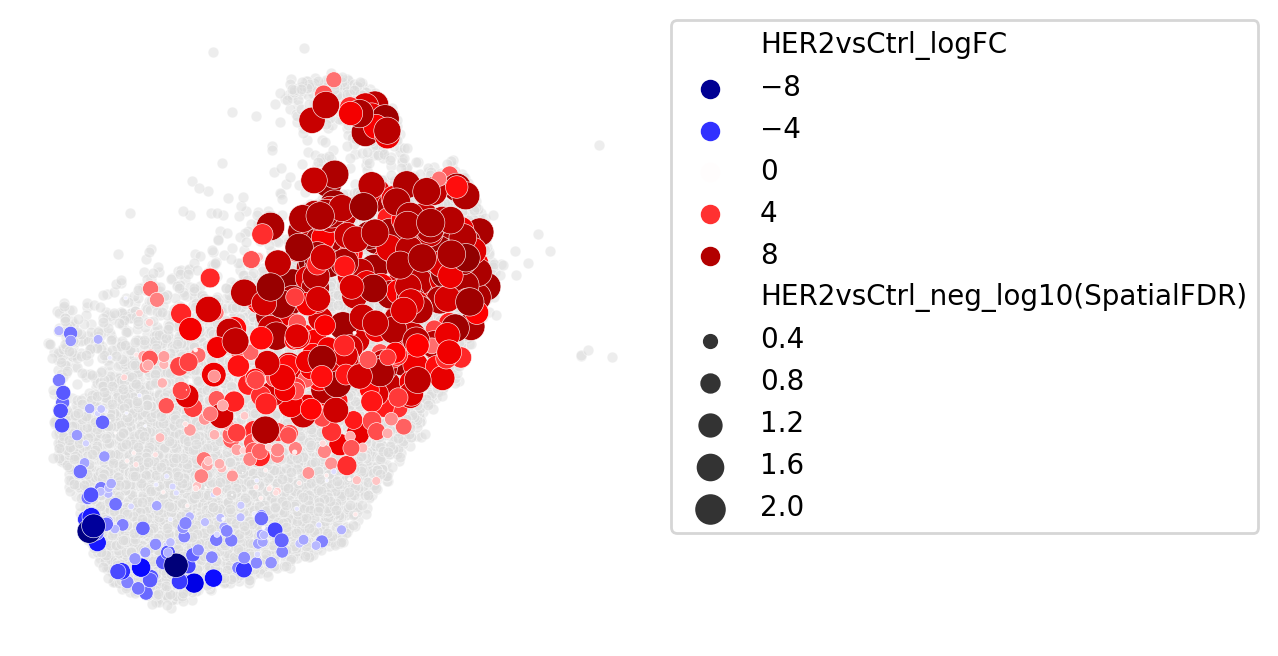

In [31]:
# Comparing HER2BC-labeled to Unlabeled
k = 'HER2vsCtrl'

# Show all cells in gray
umap = pd.DataFrame(adata.obsm['X_umap'],
                    columns = ["UMAP_1","UMAP_2"])
ax = sns.scatterplot(data=umap, x="UMAP_1", y="UMAP_2", 
                     alpha=0.5, color='gainsboro', s=15) 

# Show all neighborhoods 
sns.scatterplot(data=fit, #.loc[da_sig_idx,:], 
                x="UMAP_1", y="UMAP_2", 
                size=k+'_neg_log10(SpatialFDR)', 
                hue=k+'_logFC', 
                palette=mpl.cm.seismic,
                hue_norm=(-10,10),
                sizes=(0.15/2,208.8/2))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_axis_off()

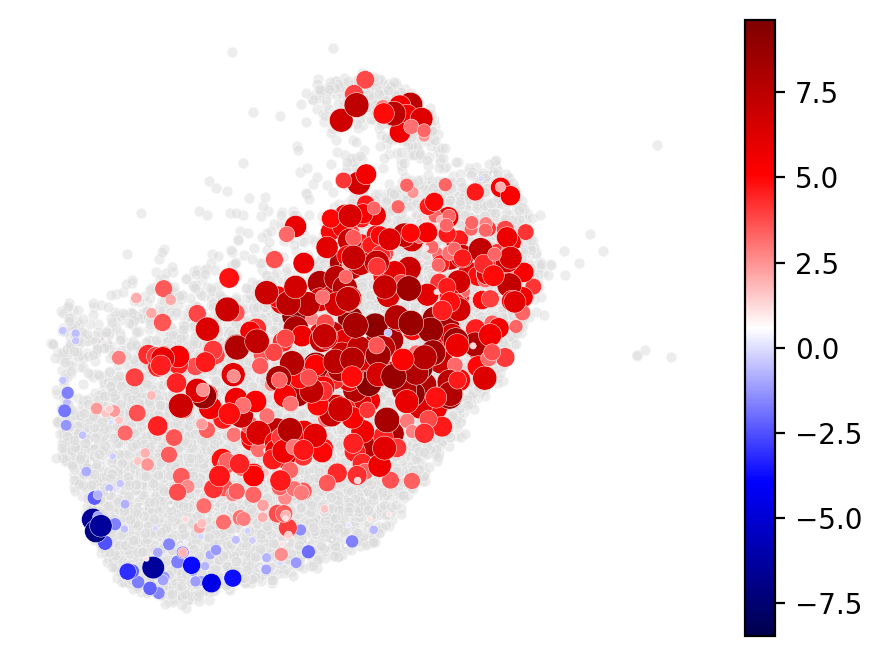

In [32]:
# Comparing TNBC-labeled to Unlabeled
k = 'TNvsCtrl'
mpl.rcParams['figure.figsize'] = [5.5,4]

# Show all cells in gray
umap = pd.DataFrame(adata.obsm['X_umap'],
                    columns = ["UMAP_1","UMAP_2"])
ax = sns.scatterplot(data=umap, x="UMAP_1", y="UMAP_2", 
                     alpha=0.5, color='gainsboro', s=15) 

# Show all neighborhoods 
sns.scatterplot(data=fit, #.loc[da_sig_idx,:], 
                x="UMAP_1", y="UMAP_2", 
                size=k+'_neg_log10(SpatialFDR)', 
                hue=k+'_logFC', 
                palette=mpl.cm.seismic,
                hue_norm=(-10,10),
                sizes=(0,169.9/2))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_axis_off()


# To show a continuous colorbar, instead of the individual dots 
norm = plt.Normalize(fit.loc[:,k+'_logFC'].min(), 
                     fit.loc[:,k+'_logFC'].max())
sm = plt.cm.ScalarMappable(cmap=mpl.cm.seismic, norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm)

## Compute neighborhood-averaged expression

In [33]:
nhood = {} # Store all neighborhoods

for f in Path(MILO_DIR).glob('*milo.nhoodDistances_*'): 
    n = str(f).split('.csv')[0].split('milo.nhoodDistances_')[-1] 
    # neighborhood index cell (in R), need to -1 to convert to Python
    k = nhoodIdx.index[np.where(nhoodIdx == int(n)-1)[0][0]]
    nhood[k] = pd.read_csv(f, index_col=0)

<b> Signature scores </b>

Here is an example of computing the neighborhood-averaged actin remodeling and type I interferon response scores, followed by the visualization of gene expression trends using the scores computed and stored in adata.

In [34]:
k = 'LabeledvsCtrl'

# List of the signatures to compute
score_list = ['Actin_poly_depoly_score','Annotated_TypeI_IFN_score']
da[k].loc[:,['nhood_'+s for s in score_list]] = np.nan

for i in da[k].index:
    
    # All cells in the neighborhood
    l = adata[nhood[i].index].obs_names 

    # Average among the cells and store the results in da 
    da[k].loc[i,['nhood_'+s for s in score_list]] = np.average(adata[l].obs[score_list], axis=0)

In [35]:
da[k].loc[:,['nhood_'+s for s in score_list]]

,nhood_Actin_poly_depoly_score,nhood_Annotated_TypeI_IFN_score
Unlabeled_stromal_cells_239451619092844-0-0,0.161558,-0.198662
Labeled_stromal_cells_135496128154852-1-0,0.174190,-0.031169
Labeled_stromal_cells_200493056781029-1-0,0.146950,0.079601
Labeled_stromal_cells_134445202820004-1-0,0.191293,-0.051876
Labeled_stromal_cells_125813258934123-1-0,0.165121,-0.047809
...,...,...
Labeled_stromal_cells_191148435131699-1-0,0.202910,0.717912
Labeled_stromal_cells_161529247951595-1-0,0.173745,-0.194341
Labeled_stromal_cells_166273863806235-1-0,0.157563,-0.148358
Labeled_stromal_cells_226884395657117-1-0,0.160265,-0.188454


<b> Gene expression </b>

Here is an example of computing the neighborhood-averaged AXL expression, followed by the visualization of gene expression trends using the values computed and stored in adata.

In [36]:
k = 'LabeledvsCtrl'
gene_list = ['AXL']
da[k].loc[:,['nhood_'+s for s in gene_list]] = np.nan

for i in da[k].index:
    # All cells in the neighborhood
    l = adata[nhood[i].index].obs_names 

    da[k].loc[i,['nhood_'+s for s in gene_list]] = np.average(adata[l,:][:,gene_list].X, axis=0)

## Compute diffusion components

Here're the example codes, while the following visualization uses the original results computed and stored in adata.

In [37]:
# adata.uns['pca']['no_pcs']: Number of PCs to use to compute diffusion components
dm = pl.utils.run_diffusion_maps(pd.DataFrame(adata.obsm['X_pca'][:,0:adata.uns['pca']['no_pcs']]), 
                                 knn=30, n_components=20)

adata.obsm['X_dm'] = np.array(dm['EigenVectors'])

Determing nearest neighbor graph...


In [38]:
dm_uns = OrderedDict()
dm_uns['adjacency'] = dm['kernel']
dm_uns['eigenvalues'] = dm['EigenValues'].values
dm_uns['T'] = dm['T'] # transition matrix

# Store the data in diffusion component results in adata 
adata.uns['dm'] = dm_uns 

In [39]:
dc = [1,2,3,4,5]
adata.obs[['Microglia_X_dm_'+str(i) for i in dc]] = np.nan

for i in dc:
    # Store the non-trivial components start from 1 
    adata.obs['Microglia_X_dm_'+str(i)][adata.obs_names] = \
    adata.obsm['X_dm'][:,i]

<b> First diffusion component (DC1) </b>

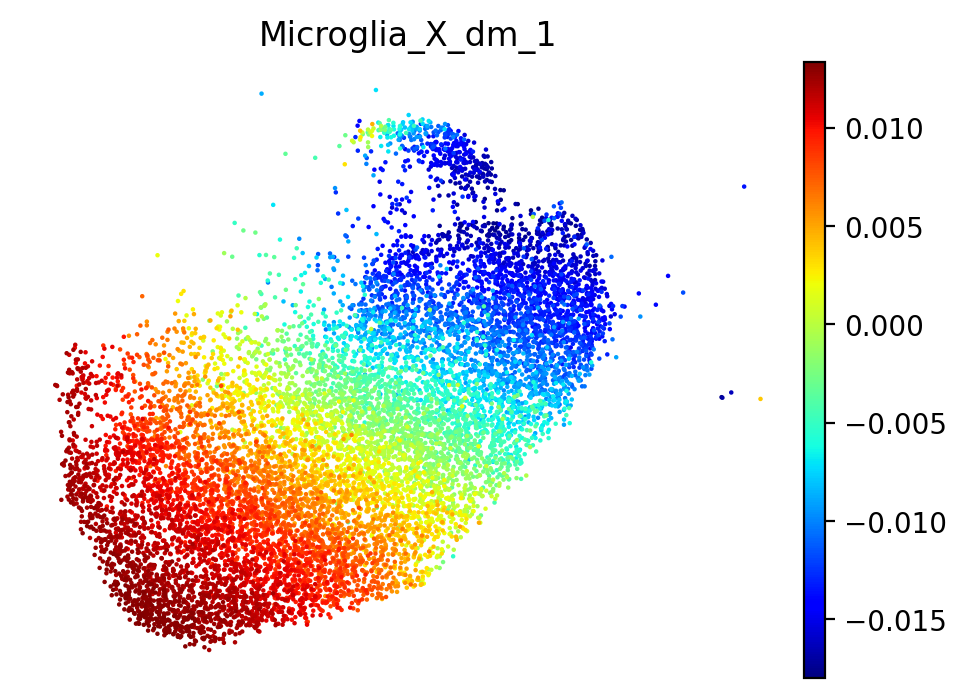

In [40]:
vis_rand = np.random.choice(range(adata.shape[0]),replace=False, size=adata.shape[0])

sc.pl.umap(adata[vis_rand], 
           color=['Microglia_X_dm_1'],
           cmap=plt.cm.jet,
           frameon=False)

## Examine gene expression trends


<b> Visualization functions adapted from Palantir (for convenience) </b>

In [41]:
# No further scaling (original pseudotime value)
class PResults_ori(object): 
    """
    Container of palantir results
    """

    def __init__(self, pseudotime, entropy, branch_probs, waypoints):

        # Initialize
        self._pseudotime = pseudotime 
        # - pseudotime.min()) / (
        # pseudotime.max() - pseudotime.min()
        # )
        self._entropy = entropy
        self._branch_probs = branch_probs
        self._branch_probs[self._branch_probs < 0.01] = 0
        self._waypoints = waypoints

    # Getters and setters
    @property
    def pseudotime(self):
        return self._pseudotime

    @property
    def branch_probs(self):
        return self._branch_probs

    @branch_probs.setter
    def branch_probs(self, branch_probs):
        self._branch_probs = branch_probs

    @property
    def entropy(self):
        return self._entropy

    @entropy.setter
    def entropy(self, entropy):
        self._entropy = entropy

    @property
    def waypoints(self):
        return self._waypoints

    @classmethod
    def load(cls, pkl_file):
        with open(pkl_file, "rb") as f:
            data = pickle.load(f)

        # Set up object
        presults = cls(
            data["_pseudotime"],
            data["_entropy"],
            data["_branch_probs"],
            data["_waypoints"],
        )
        return presults

In [42]:
def plot_gene_trend_heatmaps(gene_trends, vmin, vmax):
    """ Plot the gene trends on heatmap: a heatmap is generated or each branch
    :param: gene_trends: Results of the compute_marker_trends function
    """

    # Plot height
    branches = list(gene_trends.keys())
    genes = gene_trends[branches[0]]["trends"].index
    height = 0.7 * len(genes) * len(branches)

    #  Set up plot
    fig = plt.figure(figsize=[7, height])
    for i, branch in enumerate(branches):
        ax = fig.add_subplot(len(branches), 1, i + 1)

        # Standardize the matrix
        mat = gene_trends[branch]["trends"]
        mat = pd.DataFrame(
            StandardScaler().fit_transform(mat.T).T,
            index=[i.replace('nhood_', '').replace('_SCANPY_score','') for i in mat.index],
            columns=mat.columns,
        )
        sns.heatmap(mat, xticklabels=False, ax=ax, cmap=mpl.cm.Spectral_r,
                    vmin=vmin, vmax=vmax)
#         sns.clustermap(mat, xticklabels=False, ax=ax, cmap=mpl.cm.Spectral_r, vmin=vmin, vmax=vmax)
        ax.set_title(branch, fontsize=12)

In [43]:
# Neighborhood index cells
MG_idx = adata.obs_names[adata.obs['nhoodIdx']]

# Smallest & largest DC1 
DC1_min = np.min(adata.obs['Microglia_X_dm_1'][MG_idx])
DC1_max = np.max(adata.obs['Microglia_X_dm_1'][MG_idx])

# DC_1 stretched to [0,1]
adata.obs['Microglia_X_dm_1_scaled'] = (adata.obs['Microglia_X_dm_1']-DC1_min)/(DC1_max-DC1_min)

# Given a single fate/lineage for the homeostasis-to-DAM transition, the branch_probs (probabilities for ...
# different fates/lineages) input to Palantir is set to 1 (binary constant data).

res = PResults_ori(pseudotime=adata.obs['Microglia_X_dm_1_scaled'],                 
                   branch_probs=pd.DataFrame(np.ones([len(MG_idx),1]),
                                             index=MG_idx,
                                             columns=['DAM']), 
                   entropy=pd.Series(np.zeros(len(MG_idx)),
                                     index=MG_idx),
                   waypoints=[])

<b> Signature scores along first diffusion component </b>

The following signatures are shown as example.

In [44]:
features = ['nhood_Amit_homeostatic_SCANPY_score',
    'TGFb_in_vivo_UP_SCANPY_score',
    'TNvsCtrl_logFC', 'HER2vsCtrl_logFC', #'TNvsHER2_logFC',
    'nhood_Disease-associated_MG_SCANPY_score',
    'nhood_Amit_stage 1 DAM_UP_SCANPY_score',
    'nhood_Amit_stage 2 DAM_SCANPY_score',
    'nhood_Actin_poly_depoly_score',
    'nhood_HALLMARK_OXIDATIVE_PHOSPHORYLATION_SCANPY_score',
    'nhood_HALLMARK_GLYCOLYSIS_SCANPY_score',]

values = adata[MG_idx].obs[features].copy()
values

,nhood_Amit_homeostatic_SCANPY_score,TGFb_in_vivo_UP_SCANPY_score,TNvsCtrl_logFC,HER2vsCtrl_logFC,nhood_Disease-associated_MG_SCANPY_score,nhood_Amit_stage 1 DAM_UP_SCANPY_score,nhood_Amit_stage 2 DAM_SCANPY_score,nhood_Actin_poly_depoly_score,nhood_HALLMARK_OXIDATIVE_PHOSPHORYLATION_SCANPY_score,nhood_HALLMARK_GLYCOLYSIS_SCANPY_score
Unlabeled_stromal_cells_201446646471582-0-0,2.503435,1.168691,-2.876475,-2.375740,0.892013,1.584201,-0.018091,0.174895,0.260467,0.026680
Unlabeled_stromal_cells_134447990462365-0-0,1.765996,0.860551,0.543671,0.456369,1.344316,2.526232,0.797122,0.176442,0.280397,0.043341
Unlabeled_stromal_cells_121889787169189-0-0,2.114653,0.894104,1.171337,-0.475012,0.976816,2.534479,0.005771,0.163001,0.284205,0.027721
Unlabeled_stromal_cells_130118829062580-0-0,1.936965,0.804630,7.157356,7.110887,0.889795,1.644503,-0.231316,0.233387,0.419244,0.061737
Unlabeled_stromal_cells_165260117600692-0-0,1.560620,0.737449,0.573079,-0.011961,1.318962,2.656867,0.932262,0.148627,0.313554,0.062816
...,...,...,...,...,...,...,...,...,...,...
Labeled_stromal_cells_126843092684148-1-0,3.173149,1.125271,2.000475,-1.722463,0.500579,1.816558,-0.392019,0.152656,0.272739,0.013710
Labeled_stromal_cells_155973292513501-1-0,2.740699,0.787044,2.839928,-1.312884,0.615433,1.963941,-0.295331,0.140592,0.207813,0.020635
Labeled_stromal_cells_169014021736235-1-0,2.207977,0.970168,1.647281,2.462184,0.776345,2.294679,0.013543,0.119832,0.188179,0.023765
Labeled_stromal_cells_121731966191349-1-0,3.064475,1.053619,2.000142,-0.358868,0.518296,1.608503,-0.364696,0.143493,0.254939,0.017509


In [45]:
feature_trends = pl.presults.compute_gene_trends(res, values) 

DAM
Time for processing DAM: 0.19128679037094115 minutes


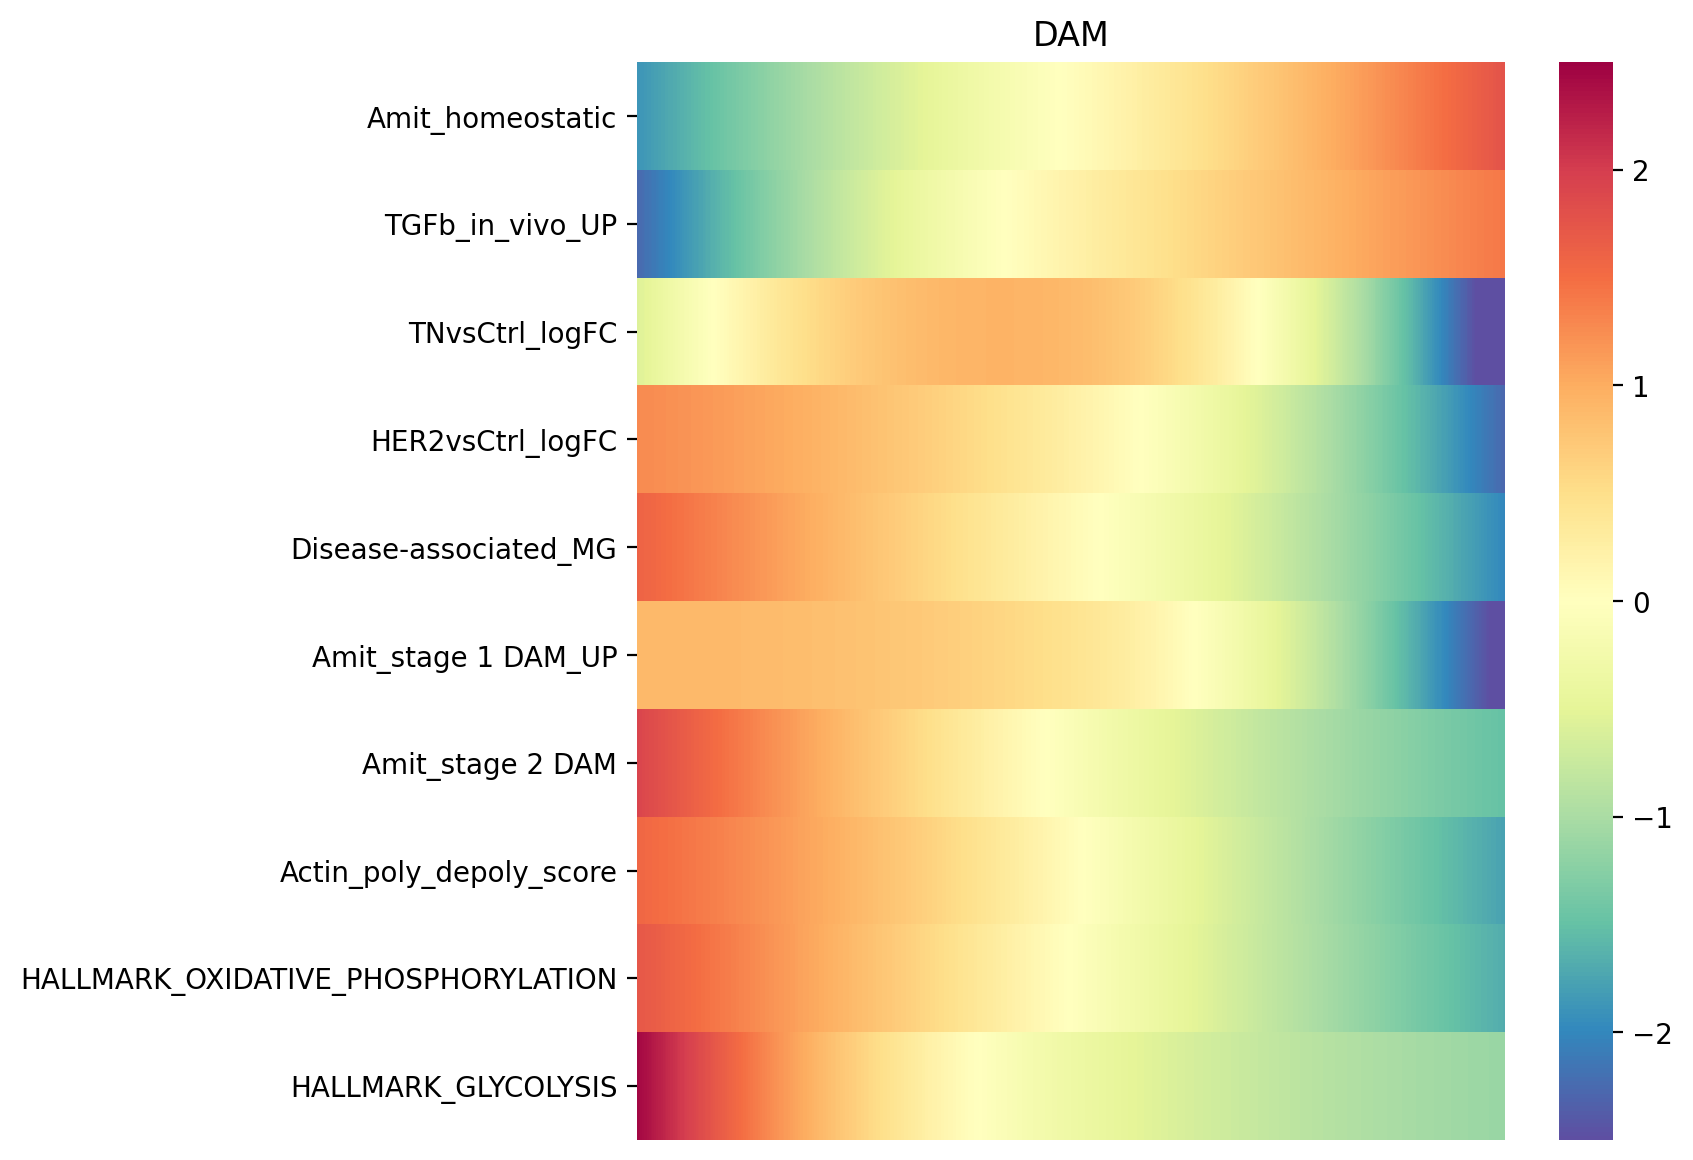

In [46]:
mpl.rcParams['figure.figsize'] = [4,10]
plot_gene_trend_heatmaps(feature_trends, vmin=-2.5, vmax=2.5)

<b> Gene expression along first diffusion component </b>

The following genes are shown as example.

In [47]:
# Stage 2 DAM markers
features = ['nhood_Amit_stage 2 DAM_SCANPY_score',
            'nhood_CSF1',
            'nhood_CCL6',
            'nhood_AXL',
            'nhood_SPP1',
            'nhood_CD9',
            'nhood_CST7',
            'nhood_ITGAX',
            'nhood_LPL',]

values = adata[MG_idx].obs[features].copy()
values

,nhood_Amit_stage 2 DAM_SCANPY_score,nhood_CSF1,nhood_CCL6,nhood_AXL,nhood_SPP1,nhood_CD9,nhood_CST7,nhood_ITGAX,nhood_LPL
Unlabeled_stromal_cells_201446646471582-0-0,-0.018091,0.821121,0.631277,0.517781,0.636464,2.915435,0.111634,0.204844,0.226575
Unlabeled_stromal_cells_134447990462365-0-0,0.797122,1.707619,0.906553,0.837436,3.570504,3.705529,0.680947,0.335252,0.897448
Unlabeled_stromal_cells_121889787169189-0-0,0.005771,0.394306,0.571557,0.575998,1.315656,2.526093,0.313384,0.225497,0.134642
Unlabeled_stromal_cells_130118829062580-0-0,-0.231316,0.375108,0.370629,0.439616,1.058230,2.065002,0.369872,0.095159,0.130948
Unlabeled_stromal_cells_165260117600692-0-0,0.932262,1.299423,1.307055,1.087541,3.476705,3.902242,0.767498,0.501026,1.070674
...,...,...,...,...,...,...,...,...,...
Labeled_stromal_cells_126843092684148-1-0,-0.392019,0.042325,0.347787,0.025947,0.023319,1.955533,0.045939,0.018322,0.000000
Labeled_stromal_cells_155973292513501-1-0,-0.295331,0.268185,0.345256,0.097837,0.108642,1.989952,0.070966,0.057491,0.014615
Labeled_stromal_cells_169014021736235-1-0,0.013543,0.233018,0.387104,0.550110,1.841039,1.718465,0.396398,0.168902,0.123594
Labeled_stromal_cells_121731966191349-1-0,-0.364696,0.024991,0.323845,0.068614,0.033169,2.072663,0.057995,0.014772,0.000000


In [48]:
feature_trends = pl.presults.compute_gene_trends(res, values) 

DAM
Time for processing DAM: 0.0004113356272379557 minutes


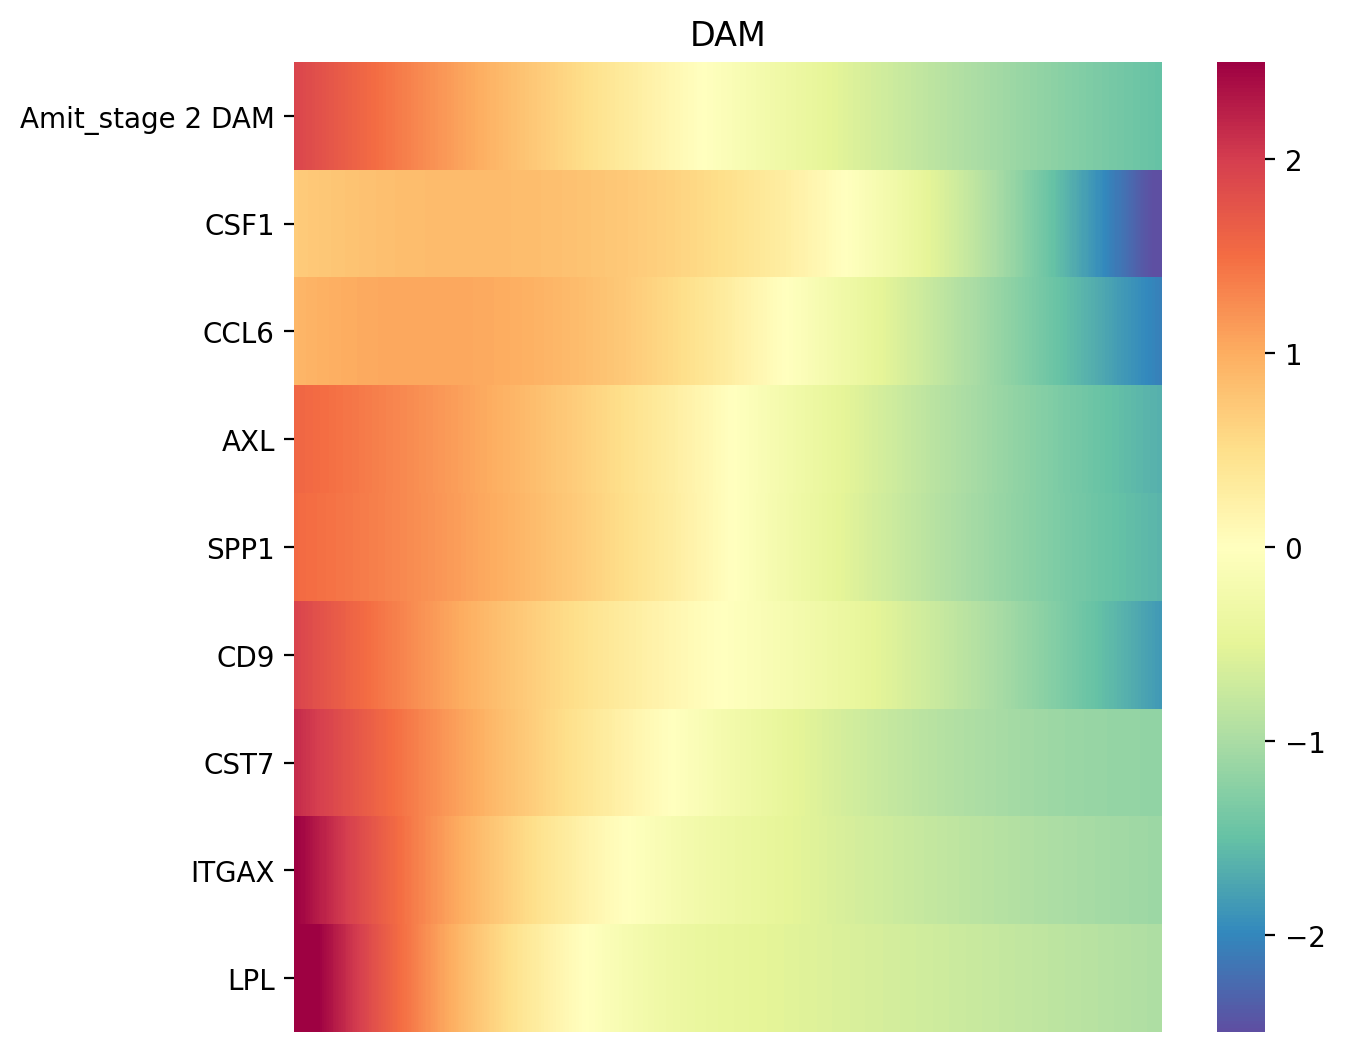

In [49]:
mpl.rcParams['figure.figsize'] = [4,10]
plot_gene_trend_heatmaps(feature_trends, vmin=-2.5, vmax=2.5)

## Examine Type I interferon  (IFN) response

<b> Finalized PhenoGraph clustering </b>

Trying to set attribute `.uns` of view, copying.


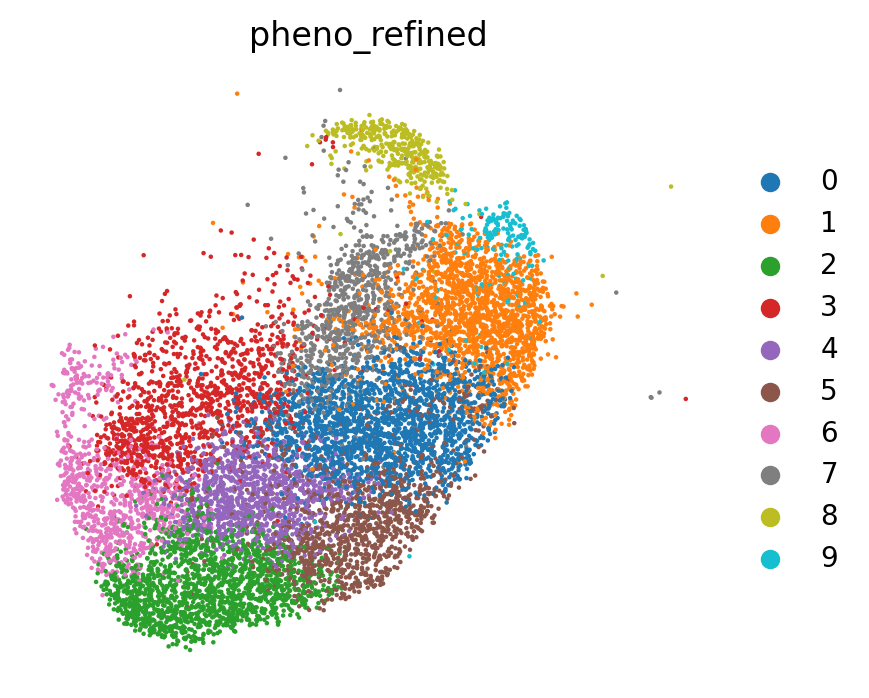

In [50]:
mpl.rcParams['figure.figsize'] = [4.5,4]

vis_rand = np.random.choice(range(adata.shape[0]),replace=False, size=adata.shape[0])

sc.pl.umap(adata[vis_rand], 
           color=['pheno_refined'],
           frameon=False)

<b> Type I IFN response </b>


Matrixplot functio in Scanpy takes variables (and not genes) as input, so need to perform the following steps to achieve the visualization using matrixplot.

In [51]:
# Put genes into temp1
temp1 = pd.DataFrame(adata[:,['AXL']].X,
                     index=adata.obs_names, 
                     columns=['AXL']) 

In [52]:
# Put vars into temp2
temp2 = pd.DataFrame(adata.obs[['Amit_homeostatic_SCANPY_score',
                                'Disease-associated_MG_SCANPY_score',
                                'Amit_stage 1 DAM_UP_SCANPY_score',
                                'Amit_stage 2 DAM_SCANPY_score',
                                'Annotated_TypeI_IFN_score',
                                'Microglia_X_dm_1']],
                     columns=['Amit_homeostatic_SCANPY_score',
                              'Disease-associated_MG_SCANPY_score',
                              'Amit_stage 1 DAM_UP_SCANPY_score',
                              'Amit_stage 2 DAM_SCANPY_score',
                              'Annotated_TypeI_IFN_score',
                              'Microglia_X_dm_1'])

In [53]:
temp = sc.AnnData(X=pd.concat([temp1, temp2], axis=1))
temp.obs[['pheno_refined']] = adata.obs[['pheno_refined']].copy()

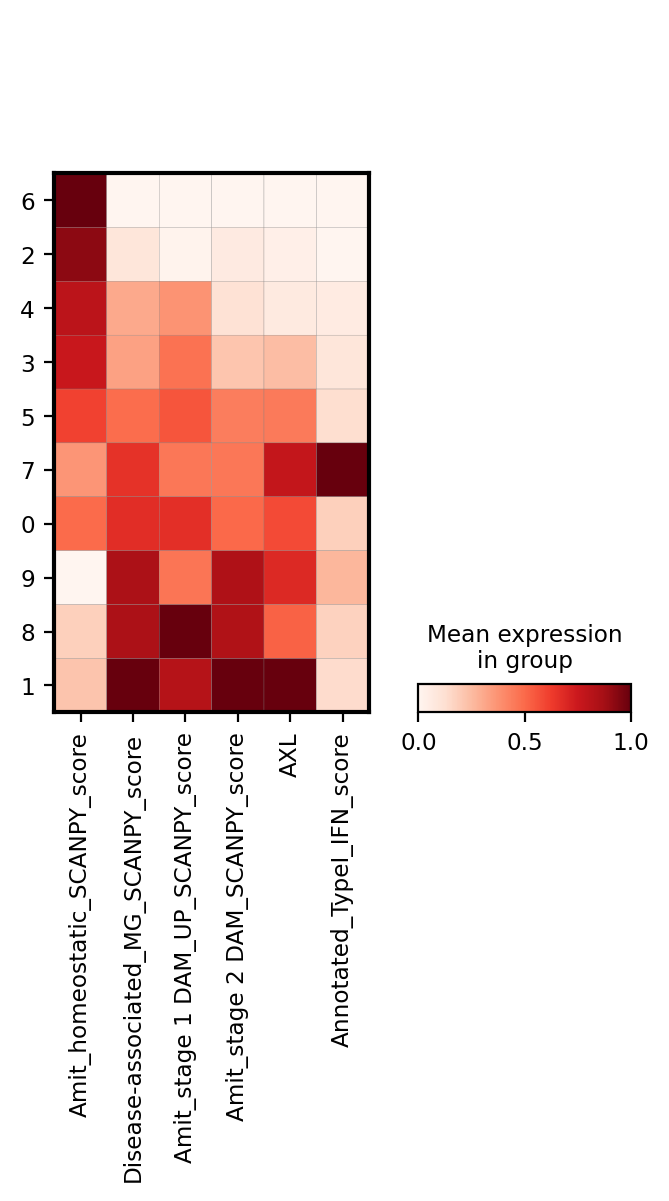

In [54]:
ax = sc.pl.matrixplot(temp, ['Amit_homeostatic_SCANPY_score',
                             'Disease-associated_MG_SCANPY_score',
                             'Amit_stage 1 DAM_UP_SCANPY_score',
                             'Amit_stage 2 DAM_SCANPY_score',
                             'AXL',
                             'Annotated_TypeI_IFN_score',
                            ],
                      categories_order = [6,2,4,3,5,7,0,9,8,1],
                      groupby='pheno_refined', 
                      standard_scale='var', cmap='Reds')

# Save results

In [55]:
# Save udpated adata to the original directory
for h5_file in Path(DATA_DIR+source).glob('*.h5'):   
    adata.write(h5_file)